In [1]:
import cv2 
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def readSignNames(csvFile):
    import csv
    labelDict = {}
    with open(csvFile, newline='', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for row in reader:
            labelDict[int(row['ClassId'])] = row['SignName']
    return labelDict

signDict = readSignNames('signnames.csv')

 0: Speed limit (20km/h)                          1: Speed limit (30km/h)                         
 2: Speed limit (50km/h)                          3: Speed limit (60km/h)                         
 4: Speed limit (70km/h)                          5: Speed limit (80km/h)                         
 6: End of speed limit (80km/h)                   7: Speed limit (100km/h)                        
 8: Speed limit (120km/h)                         9: No passing                                   
10: No passing for vehicles over 3.5 metric to   11: Right-of-way at the next intersection        
12: Priority road                                13: Yield                                        
14: Stop                                         15: No vehicles                                  
16: Vehicles over 3.5 metric tons prohibited     17: No entry                                     
18: General caution                              19: Dangerous curve to the left                  
20: Danger

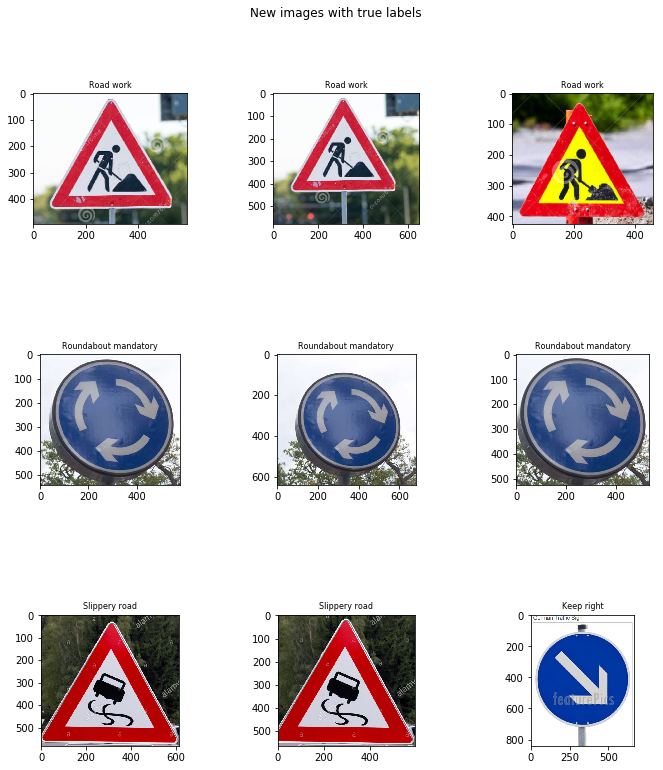

In [2]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def visualizeNewImages(imgFiles, classIds=None, title='New images', rows=3, cols=3):
    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 12), gridspec_kw={'hspace': 1})
    fig.suptitle(title)    
    i = 0
    for imgFile in imgFiles:
        img = mpimg.imread(imgFile)
        
        # Remove the last alpha channel
        img = img[:,:,:3]        
        ax[i//rows, i%cols].imshow(img)
        if classIds is not None:
            classId = classIds[i]
            label = signDict[classId][:40]
            ax[i//rows, i%cols].set_title(label, fontsize=8)            
        i +=1
    for i in range(len(signDict)):
        print("{:>2}: {:<45}".format(i, signDict[i][:42]), end='')
        if i % 2 == 1:
            print()
        
trueClasses = np.array([25, 25 , 25, 40, 40, 40, 23, 23, 38])
newImageFiles = ['new2/{}.PNG'.format(i) for i in range(1, 10)]
visualizeNewImages(newImageFiles, trueClasses, title='New images with true labels')

In [3]:
### Model architecture implementation.
import tensorflow as tf
class LeNet5:    
    def __init__(self, channels=3, n_classes=43, mu = 0, sigma = 0.1, rate=0.001):
        def conv2d(x, W, bias, s=1, pad='VALID'):
            z = tf.nn.conv2d(x, W, strides = [1, s, s, 1], padding=pad)
            z = tf.nn.bias_add(z, bias)
            z = tf.nn.relu(z)
            return z

        def maxpool2d(x, k=2, s=2, pad='VALID'):
            pool = tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, s, s, 1], padding=pad)
            return pool
        
        K1 = 38
        K2 = 64
        FCK1 = 120
        FCK2 = 84
        
        self.x = tf.placeholder(tf.float32, (None, 32, 32, channels))
        self.y = tf.placeholder(tf.int32, (None))
        self.keep_prob = tf.placeholder(tf.float32)    
    
        # Convolutional layer 1. Input: 32x32xchannels. Ouuput: 28x28xK1
        w1 = tf.Variable(tf.truncated_normal([5, 5, channels, K1], mean=mu, stddev=sigma))
        b1 = tf.Variable(tf.zeros([K1]))
        conv1 = conv2d(self.x, w1, b1)

        # Input:  Input 28x28xK1. Ouuput: 14x14xK1
        pool1 = maxpool2d(conv1)

        # Convolutional layer 2. Input: 14x14xK1. Ouuput: 10x10xK2
        w2 = tf.Variable(tf.truncated_normal([5, 5, K1, K2], mean=mu, stddev=sigma))
        b2 = tf.Variable(tf.zeros([K2]))
        conv2 = conv2d(pool1, w2, b2)

        # Pooling. Input: 10x10xK2. Output: 5x5xK2.
        pool2 = maxpool2d(conv2)

        # Layer 3: Fully Connected. Input: 5x5xK2. Output: FCK1.
        fc1 = tf.reshape(pool2, [-1, 5*5*K2])
        wd1 = tf.Variable(tf.truncated_normal([5*5*K2, FCK1], mean=mu, stddev=sigma))
        bd1 = tf.Variable(tf.zeros([FCK1]))
        fc1 = tf.add(tf.matmul(fc1, wd1), bd1)
        fc1 = tf.nn.dropout(fc1, self.keep_prob)
        fc1 = tf.nn.relu(fc1)

        # Layer 4: Fully Connected. Input: FCK1. Output: FCK2
        wd2 = tf.Variable(tf.truncated_normal([FCK1, FCK2], mean=mu, stddev=sigma))
        bd2 = tf.Variable(tf.zeros([FCK2]))
        fc2 = tf.add(tf.matmul(fc1, wd2), bd2)
        fc2 = tf.nn.dropout(fc2, self.keep_prob)
        fc2 = tf.nn.relu(fc2)

        # Layer 5: Fully Connected. Input: FCK2. Output: n_classes
        wd3 = tf.Variable(tf.truncated_normal([FCK2, n_classes], mean=mu, stddev=sigma))
        bd3 = tf.Variable(tf.zeros([n_classes]))        
        self.logits = tf.add(tf.matmul(fc2, wd3), bd3)        
        self.probs  = tf.nn.softmax(self.logits)
        self.yhats = tf.argmax(self.logits, 1)

        self.one_hot_y = tf.one_hot(self.y, n_classes)        
        self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.logits, labels=self.one_hot_y))
        self.training = tf.train.AdamOptimizer(learning_rate = rate).minimize(self.loss)

        self.correct_pred = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.one_hot_y, 1))
        self.sum_correct_preds = tf.reduce_sum(tf.cast(self.correct_pred, tf.float32))
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_pred, tf.float32))
        self.saver = tf.train.Saver()
        
    def train(self, X_train, y_train, X_valid, y_valid, epochs = 25, batch_size=256):
        self.train_accuracies = []
        self.validation_accuracies = []
        self.epochs = epochs
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            
            print("Training...")
            for i in range(self.epochs):
                X_train, y_train = shuffle(X_train, y_train)
                train_correct_preds = 0
                for k in range(0, len(X_train), batch_size):
                    batch_x, batch_y = X_train[k:k+batch_size], y_train[k:k+batch_size]
                    sess.run(self.training, feed_dict={self.x: batch_x, self.y: batch_y, self.keep_prob: 0.5})
                    correct_preds = sess.run(self.sum_correct_preds, feed_dict={self.x: batch_x, self.y: batch_y, self.keep_prob: 1.0})
                    train_correct_preds += correct_preds

                train_accuracy = train_correct_preds / len(X_train)
                validation_accuracy = sess.run(self.accuracy, feed_dict={self.x: X_valid, self.y: y_valid, self.keep_prob: 1.0})
                print("EPOCH {} ...".format(i+1))
                print("Training Accuracy   = {:.3f}".format(train_accuracy))
                print("Validation Accuracy = {:.3f}".format(validation_accuracy))
                print()
                self.train_accuracies.append(train_accuracy)
                self.validation_accuracies.append(validation_accuracy)
            
            filename = "{}".format(uuid.uuid4())
            self.modelName = os.path.join('savedModel', filename)
            self.saver.save(sess, self.modelName)
            print("Traffic sign classification Model {} saved".format(self.modelName))
            
    def plotLearningCurve(self):
        plt.figure(figsize=(10, 10))
        epochs = range(1, self.epochs+1)
        plt.plot(epochs, self.train_accuracies, label='train')
        plt.plot(epochs, self.validation_accuracies, label='validation')
        plt.title('Training and Validation Accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epochs')
        plt.xticks(epochs)
        plt.legend(loc='center right')
    
    def evaluate(self, X_test, y_test, k=3):
        with tf.Session() as sess:
            self.saver.restore(sess, self.modelName)            
            test_accuracy = sess.run(self.accuracy, feed_dict={self.x: X_test, self.y: y_test, self.keep_prob: 1.0})
            
            topk = tf.nn.top_k(self.probs, k)
            pred_probs, pred_classes = sess.run(topk, feed_dict={self.x: X_test, self.y: y_test, self.keep_prob: 1.0})
            
            yhats = sess.run(self.yhats, feed_dict={self.x: X_test, self.y: y_test, self.keep_prob: 1.0})
                        
            print("Test Accuracy = {:.3f}".format(test_accuracy))
            return test_accuracy, yhats, pred_probs, pred_classes

    def predict(self, X_test, k=3):
        with tf.Session() as sess:
            self.saver.restore(sess, self.modelName)
            topk = tf.nn.top_k(self.probs, k)
            pred_probs, pred_classes = sess.run(topk, feed_dict={self.x: X_test, self.keep_prob: 1.0})
            yhats = sess.run(self.yhats, feed_dict={self.x: X_test, self.keep_prob: 1.0})
            return yhats, pred_probs, pred_classes
        

In [4]:
def resizeImages(imgFiles, newSize=(32, 32)):
    images = []
    for imgFile in imgFiles:
        img = mpimg.imread(imgFile)
        img = cv2.resize(img, newSize)
        img = img[:,:,:3]
        img = np.expand_dims(img, axis=0)
        images.append(img)        
    return np.concatenate(images)

restoreModel = LeNet5()
restoreModel.modelName = 'savedModel/efd564b0-ba62-49ea-af57-c38044d1e2d1'

In [5]:
newImages = resizeImages(newImageFiles)
test_accuracy, yhats, pred_probs, pred_classes = restoreModel.evaluate(newImages, trueClasses, k=5)
i = 1
for tclass, clazzs, probs in zip(trueClasses, pred_classes, pred_probs):
    print("IMAGE {:>1}...  True class: {:<25}".format(i, signDict[tclass][:25]))
    for c, prob in zip(clazzs, probs):
        print("   Prediction: {:<42} Probability {:.4f}".format(signDict[c][:40], prob))
    i +=1

INFO:tensorflow:Restoring parameters from savedModel/efd564b0-ba62-49ea-af57-c38044d1e2d1
Test Accuracy = 1.000
IMAGE 1...  True class: Road work                
   Prediction: Road work                                  Probability 1.0000
   Prediction: Speed limit (20km/h)                       Probability 0.0000
   Prediction: Speed limit (30km/h)                       Probability 0.0000
   Prediction: Speed limit (50km/h)                       Probability 0.0000
   Prediction: Speed limit (60km/h)                       Probability 0.0000
IMAGE 2...  True class: Road work                
   Prediction: Road work                                  Probability 0.9107
   Prediction: Double curve                               Probability 0.0838
   Prediction: Stop                                       Probability 0.0032
   Prediction: Priority road                              Probability 0.0016
   Prediction: Beware of ice/snow                         Probability 0.0004
IMAGE 3...  True c